## Introducton

Forecasting energy prices in Germany is a challenging task due to the complex interplay of multiple factors, including renewable energy generation, fossil fuel prices, weather conditions, and market regulations. The growing share of renewables in the country’s power grid has introduced additional volatility, making accurate price prediction even more difficult.

Our project, the “BTW 2025 Data Science Challenge,” aims to develop predictive models to forecast hourly energy prices for Germany on February 18, 2025, using historical data. This report begins with an overview of the domain knowledge surrounding Germany’s energy market, followed by a discussion of the data sources used in modeling. Subsequent sections will detail the methodology, present modeling results, and offer conclusions.

In [ ]:
import pandas as pd
from prophet import Prophet
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mae, init_prophet_model, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted
from src.scraping import update_e_mix_data, update_e_price_data, fetch_historical
from src.benchmark import extend_by_predictions_and_samples

import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

## 1. Background & Domain Knowledge

### 1.1 Energy Market and Price Dynamics
In Germany, electricity pricing comprises consumer electricity fees and wholesale market prices, with the day-ahead market being a key indicator of wholesale price fluctuations. Prices in this market are determined by the “merit order principle,” in which power plants with the lowest marginal costs are utilized first to meet demand. Because renewable energy sources generally have low marginal costs, they are dispatched preferentially. However, oversupply or limitations in the grid can lead to negative prices (Wissenschaftliche Dienste, 2022). These dynamics underscore the importance of closely examining both supply-side and demand-side variables when forecasting energy prices.

### 1.2 Energy Mix
Germany’s energy mix has evolved significantly, with the share of renewables reaching about 50% of total generation in 2023 (BMWK-Energiewende, 2024). Among these, wind and solar power dominate:
- Wind Power: Peaks during winter to spring due to higher wind speeds, typically exerting downward pressure on prices (Clean Energy Wire).
- Solar Power: Generates more electricity in summer, reducing prices during daylight hours (Sebastian Kolb, 2020; IMF, 2022).

Despite the rise in renewables, fossil fuels—including hard coal, lignite, and natural gas—still play a critical role. They contribute to price volatility, influenced by fluctuating fuel costs and carbon pricing (Nature, 2024). Understanding both the renewable and fossil-fuel components of the energy mix is therefore crucial for accurate price forecasting.

#### Scraped Hourly Next-Day Energy Prices

In [78]:
dfs_to_merge = []

df = pd.read_csv('../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
dfs_to_merge.append(df)
df

,Price
Datetime,
2025-02-01 23:00:00,131.74
2025-02-01 22:00:00,141.73
2025-02-01 21:00:00,145.24
2025-02-01 20:00:00,156.60
2025-02-01 19:00:00,162.98
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


#### Scraped Hourly Energy Mix

In [79]:
mix_df = pd.read_csv('../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
dfs_to_merge.append(mix_df)
mix_df

,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2025-02-03 00:00:00,4.800,5.386,1.806,12.566,13.349,0.000,2.669,0.075,0.0,1.338,1.044
2025-02-02 23:00:00,4.818,5.475,1.776,12.555,14.162,0.000,2.619,0.120,0.0,0.946,1.094
2025-02-02 22:00:00,4.836,5.488,1.883,12.555,15.222,0.000,2.633,0.175,0.0,0.869,1.291
2025-02-02 21:00:00,4.856,5.780,1.921,12.574,15.941,0.000,2.682,0.183,0.0,1.054,1.440
2025-02-02 20:00:00,4.873,6.149,1.956,12.569,16.545,0.000,2.760,0.691,0.0,1.038,1.495
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 04:00:00,5.296,1.466,2.162,7.041,7.333,4.718,1.907,0.006,0.0,3.260,32.495
2018-01-01 03:00:00,5.290,1.469,2.168,7.059,7.267,4.911,1.857,0.005,0.0,3.183,32.611
2018-01-01 02:00:00,5.285,1.485,2.186,7.103,7.164,4.612,1.906,0.441,0.0,3.142,31.715


In [80]:
# update_e_price_data()
update_e_mix_data()
# fetch_historical()


4.8 Biomass
5.386 Hard Coal
1.806 Hydro
12.566 Lignite
13.349 Natural Gas
2.669 Other
0.075 Pumped storage generation
0.0 Solar
1.338 Wind offshore
1.044 Wind onshore
No new data added.


In [81]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 3), description='Prediction Date')

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

In [82]:
# merged_df, e_price_df = get_datasets(prediction_date_picker.value)
merged_df, e_price_df = get_datasets()
merged_df

Loading E-Prices
Last E-Price from: 2025-02-01 23:00:00
Last energy mix from: 2025-02-03 00:00:00


,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,59.53,5.319,8.294,1.166,15.866,8.697,7.929,2.309,0.194,0.0,1.650,4.372,9.660435,0.004348,17.720478,0.0
2018-10-01 01:00:00,56.10,5.284,7.975,1.131,15.927,8.787,7.941,2.341,0.194,0.0,2.115,4.080,9.375652,0.047826,16.909334,0.0
2018-10-01 02:00:00,51.41,5.291,7.797,1.118,16.009,9.019,7.962,2.336,0.194,0.0,2.176,3.995,9.129999,0.052174,18.927275,0.0
2018-10-01 03:00:00,47.38,5.279,8.214,1.128,16.078,8.605,7.871,2.329,0.194,0.0,2.234,4.268,8.856087,0.073913,19.802275,0.0
2018-10-01 04:00:00,47.59,5.293,8.523,1.127,16.139,8.373,7.895,2.339,0.194,0.0,2.600,4.722,8.758261,0.113043,20.606785,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 20:00:00,162.66,4.820,7.275,2.025,11.780,18.353,0.000,2.659,1.448,0.0,0.871,7.342,0.927826,0.000000,13.539665,0.0
2025-01-31 21:00:00,152.70,4.805,7.249,1.946,11.783,17.420,0.000,2.651,0.367,0.0,0.913,6.898,0.375652,0.000000,13.573805,0.0
2025-01-31 22:00:00,144.31,4.768,7.205,1.945,11.902,15.604,0.000,2.657,0.190,0.0,0.951,6.207,-0.137391,0.000000,13.720299,0.0
2025-01-31 23:00:00,131.41,4.756,7.163,1.961,12.052,13.641,0.000,2.659,0.312,0.0,0.913,5.833,-0.543913,0.000000,14.069579,0.0


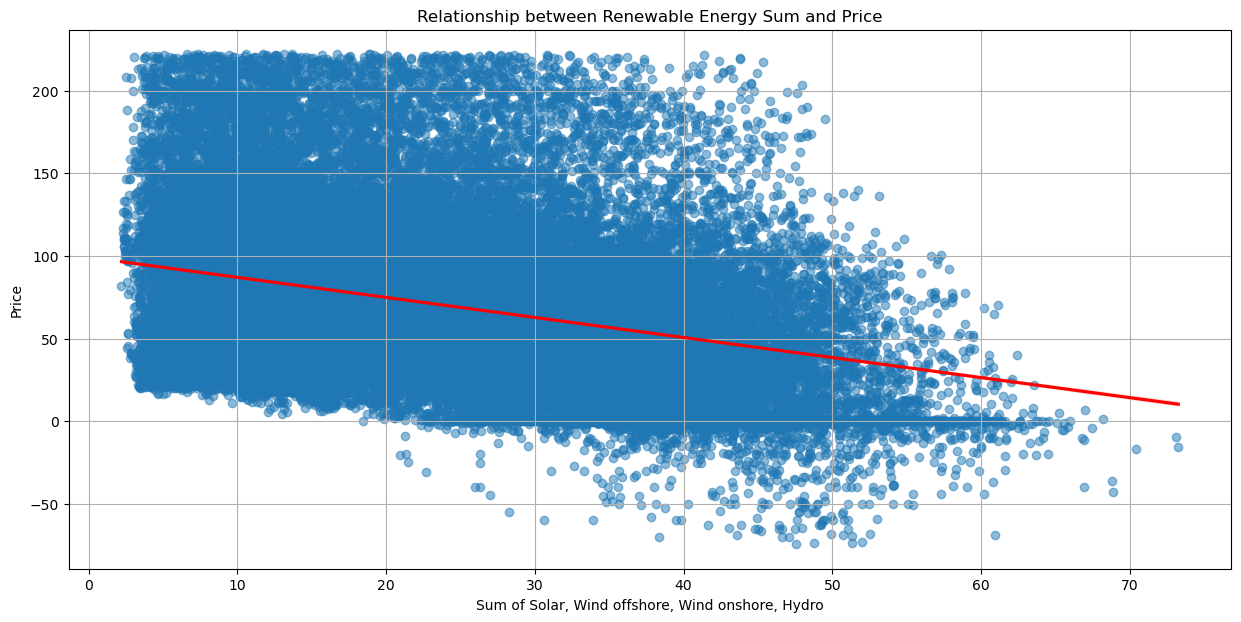

(-0.3049492055768431, 1.1102230246251565e-16)

In [84]:
price_df = pd.read_csv('../data/day_ahead_energy_prices.csv')
price_df.rename(columns={"Datetime": "Timestamp", "hourly day-ahead energy price": "Price"}, inplace=True)

min_price = -74.44
max_price = 222.01

# Filter the dataframe to remove rows with energy prices outside the range
price_df = price_df[
    (price_df['Price'] >= min_price) &
    (price_df['Price'] <= max_price)
]

# energy_mix_df = pd.read_csv("../data/hourly_market_mix_delta_abs.csv")
energy_mix_df = pd.read_csv("../data/hourly_market_mix_cleaned.csv")
# Merge datasets on timestamp
merged_df = pd.merge(energy_mix_df, price_df, on='Timestamp', how='inner')

# Set the Timestamp column as the index
merged_df.set_index('Timestamp', inplace=True)

# Calculate the sum of the specified columns
min_price = -74.44
max_price = 222.01

# Filter the dataframe to remove rows with energy prices outside the range
merged_df = merged_df[
    (merged_df['Price'] >= min_price) &
    (merged_df['Price'] <= max_price)
]

merged_df['Renewable_Sum'] = merged_df[['Solar', 'Wind offshore', 'Wind onshore', 'Hydro']].sum(axis=1)
# Plot the relationship with a correlation line
plt.figure(figsize=(15, 7))
sns.regplot(x='Renewable_Sum', y='Price', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Relationship between Renewable Energy Sum and Price')
plt.xlabel('Sum of Solar, Wind offshore, Wind onshore, Hydro')
plt.ylabel('Price')
plt.grid(True)
plt.show()

r, p_two_tailed = pearsonr(merged_df[['Solar', 'Wind offshore', 'Wind onshore', 'Hydro']].sum(axis=1), merged_df['Price'])

if p_two_tailed == 0.0:
    p_two_tailed = np.finfo(float).eps  # Assign the smallest positive float value

p_one_tailed = p_two_tailed / 2

r,  p_one_tailed

### 1.3 Weather Impacts
Weather conditions significantly affect energy supply and demand, thereby influencing prices. Key factors include:
- Wind Speeds: Higher winds, especially in northern Germany, boost renewable generation and typically lower prices (Tanaka et al., 2022; Mosquera-Lopez et al., 2024).
- Solar Irradiance: Stronger sunlight in southern regions increases solar power output, putting downward pressure on prices.
- Temperature:
  - Low Temperatures → Increased heating demand → Higher prices
  - High Temperatures → Increased cooling demand → Higher prices
- Precipitation: Affects prices with a delayed impact, possibly by influencing hydropower generation or overall energy demand (Mosquera-Lopez et al., 2024; Springer, 2022; IMF, 2022).

#### Scraped Weather Forecast Data

In [51]:
weather_forecast_df = pd.read_csv("../data/weather_forcast_prediciton.csv")[::-1]
weather_forecast_df.set_index("date" ,inplace=True)
weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
weather_forecast_df.rename_axis("Datetime",inplace=True)
weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

weather_forecast_df.rename(columns={
   "temperature_2m": "pred_temperature_2m",
   "temperature_2m_previous_day1": "pred_temperature_2m_previous_day1",
   "temperature_2m_previous_day2": "pred_temperature_2m_previous_day2",
   "temperature_2m_previous_day3": "pred_temperature_2m_previous_day3",
   "temperature_2m_previous_day4": "pred_temperature_2m_previous_day4",
   "temperature_2m_previous_day5": "pred_temperature_2m_previous_day5",
   "temperature_2m_previous_day6": "pred_temperature_2m_previous_day6",
   "temperature_2m_previous_day7": "pred_temperature_2m_previous_day7",
   "relative_humidity_2m": "pred_relative_humidity_2m",
   "relative_humidity_2m_previous_day1": "pred_relative_humidity_2m_previous_day1",
   "relative_humidity_2m_previous_day2": "pred_relative_humidity_2m_previous_day2",
   "relative_humidity_2m_previous_day3": "pred_relative_humidity_2m_previous_day3",
   "relative_humidity_2m_previous_day4": "pred_relative_humidity_2m_previous_day4",
   "relative_humidity_2m_previous_day5": "pred_relative_humidity_2m_previous_day5",
   "relative_humidity_2m_previous_day6": "pred_relative_humidity_2m_previous_day6",
   "relative_humidity_2m_previous_day7": "pred_relative_humidity_2m_previous_day7",
   "precipitation": "pred_precipitation",
      "precipitation_previous_day1": "pred_precipitation_previous_day1",
   "precipitation_previous_day2": "pred_precipitation_previous_day2",
   "precipitation_previous_day3": "pred_precipitation_previous_day3",
   "precipitation_previous_day4": "pred_precipitation_previous_day4",
   "precipitation_previous_day5": "pred_precipitation_previous_day5",
   "precipitation_previous_day6": "pred_precipitation_previous_day6",
   "precipitation_previous_day7": "pred_precipitation_previous_day7",
   "surface_pressure": "pred_surface_pressure",
   "surface_pressure_previous_day1": "pred_surface_pressure_previous_day1",
   "surface_pressure_previous_day2": "pred_surface_pressure_previous_day2",
   "surface_pressure_previous_day3": "pred_surface_pressure_previous_day3",
   "surface_pressure_previous_day4": "pred_surface_pressure_previous_day4",
   "surface_pressure_previous_day5": "pred_surface_pressure_previous_day5",
   "surface_pressure_previous_day6": "pred_surface_pressure_previous_day6",
   "surface_pressure_previous_day7": "pred_surface_pressure_previous_day7",
   "shortwave_radiation": "pred_shortwave_radiation",
   "shortwave_radiation_previous_day1": "pred_shortwave_radiation_previous_day1",
   "shortwave_radiation_previous_day2": "pred_shortwave_radiation_previous_day2",
   "shortwave_radiation_previous_day3": "pred_shortwave_radiation_previous_day3",
   "shortwave_radiation_previous_day4": "pred_shortwave_radiation_previous_day4",
   "shortwave_radiation_previous_day5": "pred_shortwave_radiation_previous_day5",
   "shortwave_radiation_previous_day6": "pred_shortwave_radiation_previous_day6",
   "shortwave_radiation_previous_day7": "pred_shortwave_radiation_previous_day7",
   "wind_speed_80m": "pred_wind_speed_80m",
   "wind_speed_80m_previous_day1": "pred_wind_speed_80m_previous_day1",
   "wind_speed_80m_previous_day2": "pred_wind_speed_80m_previous_day2",
   "wind_speed_80m_previous_day3": "pred_wind_speed_80m_previous_day3",
   "wind_speed_80m_previous_day4": "pred_wind_speed_80m_previous_day4",
   "wind_speed_80m_previous_day5": "pred_wind_speed_80m_previous_day5",
   "wind_speed_80m_previous_day6": "pred_wind_speed_80m_previous_day6",
   "wind_speed_80m_previous_day7": "pred_wind_speed_80m_previous_day7",
}, inplace=True)

# dfs_to_merge.append(weather_forecast_df)

weather_forecast_df

,pred_temperature_2m_previous_day1,pred_relative_humidity_2m_previous_day1,pred_precipitation_previous_day1,pred_surface_pressure_previous_day1,pred_shortwave_radiation_previous_day1,pred_wind_speed_80m_previous_day1
Datetime,,,,,,
2024-10-29 22:00:00,11.490999,9.490999,11.063000,9.613,11.113000,9.090000
2024-10-29 21:00:00,11.490999,9.790999,11.363000,10.013,11.363000,9.290000
2024-10-29 20:00:00,11.490999,9.591000,11.613000,10.263,11.863000,9.440001
2024-10-29 19:00:00,11.990999,10.091000,12.063000,10.563,12.513000,9.640000
2024-10-29 18:00:00,12.441000,11.040999,12.662999,10.813,13.212999,9.990001
...,...,...,...,...,...,...
2018-05-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN


#### Scraped Actual Weather Data

In [54]:
daily_weather_df = pd.read_csv('../data/daily_weather.csv', delimiter=",")

daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

daily_weather_df.index = daily_weather_df.index.tz_localize(None)

daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_100m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation', 
    }, inplace=True)

dfs_to_merge.append(daily_weather_df)
daily_weather_df

FileNotFoundError: [Errno 2] No such file or directory: '../data/daily_weather.csv'

## 2. Data Cleaning & Exploratory Data Analysis (EDA)

## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [ ]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [ ]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



2024-12-31
2024-12-31


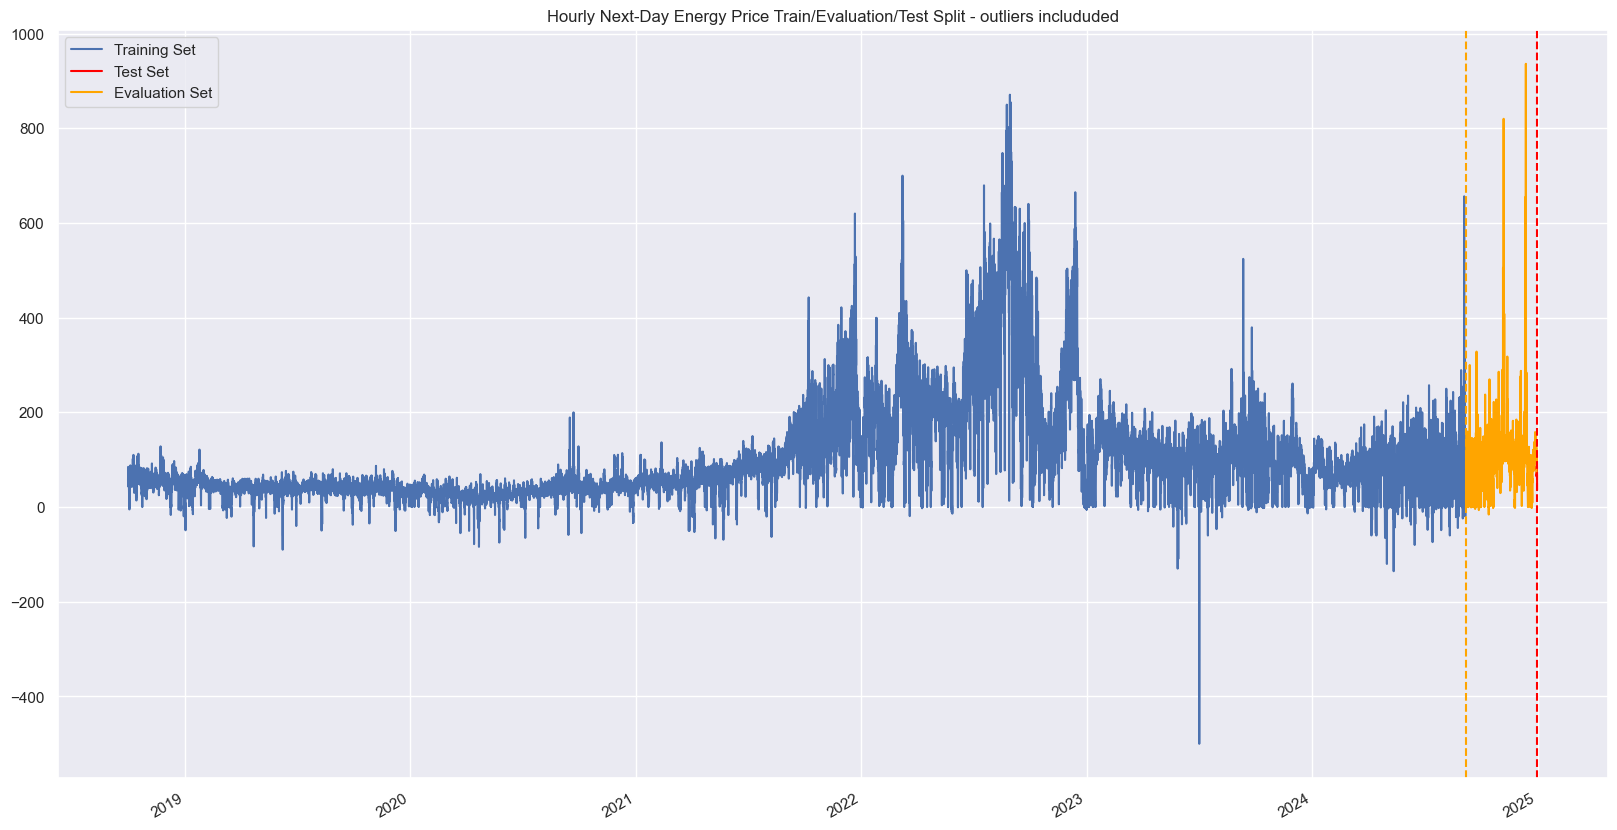

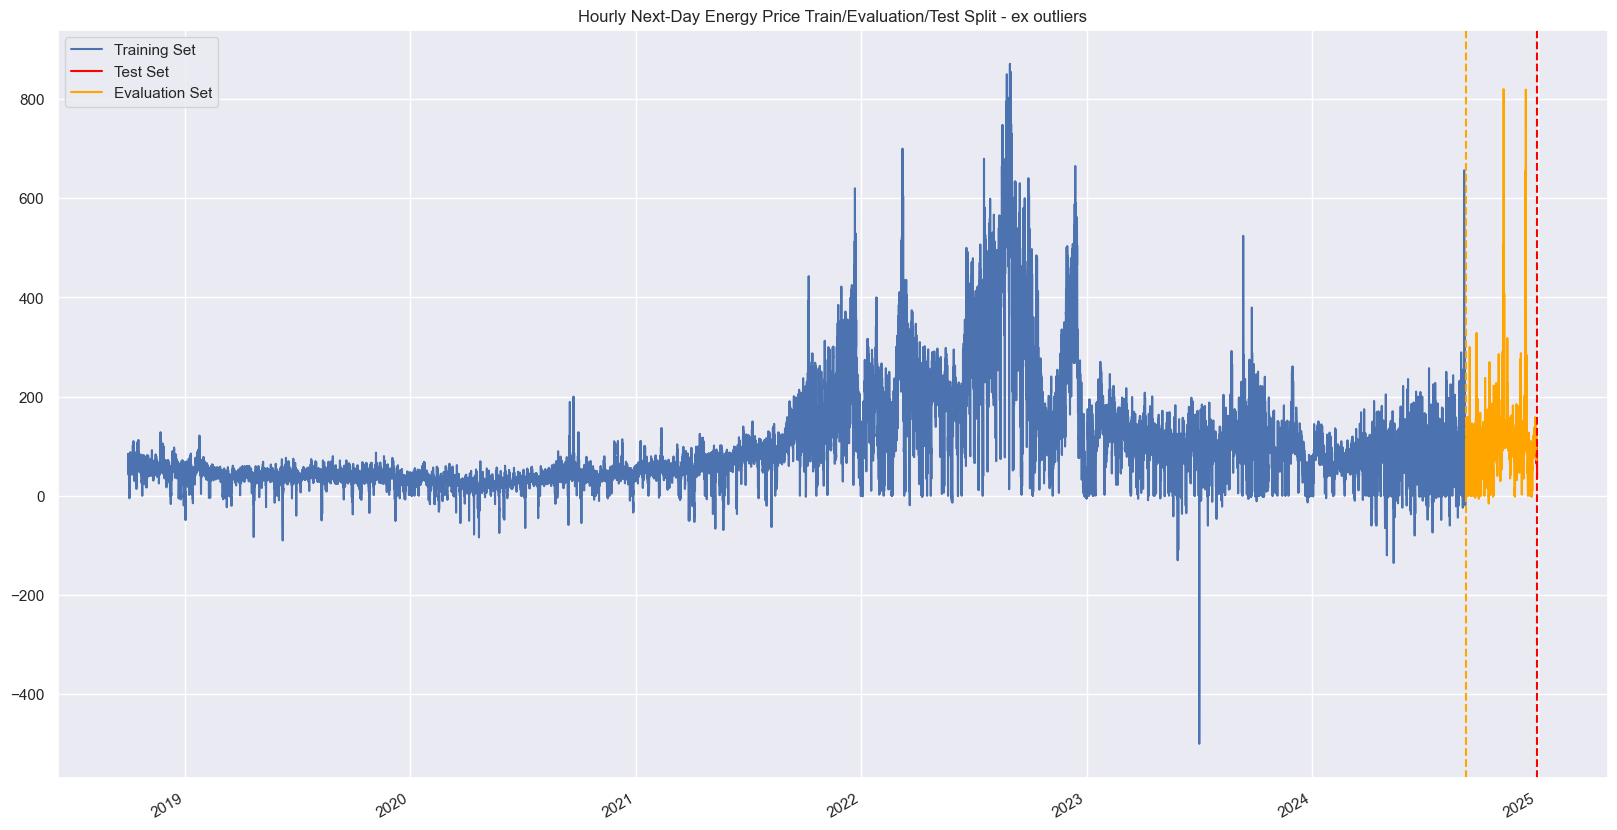

In [ ]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [ ]:
# lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
# lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [ ]:
# best_params = {
#     "base_score": 0.380924762889507,
#     "early_stopping_rounds": 215,
#     "max_depth": 80,
#     "learning_rate": 0.06,
#     "n_estimators": 150,
#     "gamma": 0.9,
#     "min_child_weight": 6,
#     "subsample": 0.5719023844219375,
#     "colsample_bytree": 0.8815691043681952,
# }
# xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
# xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


[0]	validation_0-rmse:109.67773
[25]	validation_0-rmse:27.17926
[50]	validation_0-rmse:13.30948
[75]	validation_0-rmse:11.51703
[100]	validation_0-rmse:11.50237
[125]	validation_0-rmse:11.39541
[149]	validation_0-rmse:11.31375
[0]	validation_0-mae:90.59244
[25]	validation_0-mae:19.71287
[50]	validation_0-mae:6.06849
[75]	validation_0-mae:4.22960
[100]	validation_0-mae:4.08365
[125]	validation_0-mae:4.03930
[149]	validation_0-mae:4.03002


### Prophet

In [ ]:
# # Initialize Prophet model
# model = Prophet(
#     changepoint_prior_scale = 0.5,
#     seasonality_prior_scale = 1.0,
#     holidays_prior_scale = 1.0,
#     seasonality_mode= 'multiplicative'
# )

# #Add fourier order for weekly and monthly seasonality
# model.add_seasonality(name='weekly', period=7, fourier_order=20)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
# model.add_seasonality(name='yearly', period=365, fourier_order=20)

# # Add time-based regressors

# for feature in FEATURES:
#      model.add_regressor(feature)
     
# train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

# model.fit(train_data)

# test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
# test_data_prophet.drop(columns=["Price"])
# prophet_predictions = model.predict(test_data_prophet)["yhat"]


## Results

### Errors

In [ ]:
# calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

### Plots

In [ ]:
# predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

# plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

In [ ]:
# feature_importance(xgb_mse, "MSE")
# feature_importance(xgb_mae, "MAE")

## Prediction

In [ ]:
# =============================================================================
# Constants and Configurations
# =============================================================================

# Forecasting window settings
HOURS_IN_LAST_MONTH = 24 * 31  # Assuming 31 days in the last month
WINDOW_SIZE = 24             # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price", "Hydro", "Pumped storage generation", "Solar", 
    "Wind offshore", "Wind onshore", "temperature_2m", "precipitation", 
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour", "dayofyear", "dayofweek",
    "Hydro", "Pumped storage generation",
    "Solar", "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation", "wind_speed_100m", "direct_radiation"
]

XGB_hyp_params = {
    "base_score": 0.380924762889507,
    # "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

# =============================================================================
# Data Preparation
# =============================================================================

# Split the data into training and benchmarking sets
training_set = merged_df.iloc[:-HOURS_IN_LAST_MONTH][COLUMNS]
benchmarking_set = combined_df.iloc[-HOURS_IN_LAST_MONTH:].copy()

# List to hold RMSE values for each forecasting window
rmses = []

# =============================================================================
# Rolling Forecast Loop
# =============================================================================

for i in range(0, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE):
    # ------------------------- Prophet Model -------------------------
    # Initialize the Prophet model with custom features.
    prophet_model = init_prophet_model(FINAL_FEATURES)
    
    # Extract actual price values for the current 24-hour window.
    y_actual = benchmarking_set.iloc[i:i + WINDOW_SIZE]["Price"]

    # Extend the training data with any benchmarking data available before the current window.
    train_extended = pd.concat((training_set.copy(), benchmarking_set.iloc[:i]))
    train_extended = extend_by_predictions_and_samples(train_extended, train_extended.index[-1])
    train_extended_features = create_features(train_extended.copy())

    # Prepare data for Prophet: 
    # - The forecast dataframe requires a datetime column named "ds".
    prophet_forecast_data = (
        train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]
        .reset_index()
        .rename(columns={"index": "ds"})
    )

    # Prepare the training data for Prophet.
    prophet_training_data = (
        train_extended_features.iloc[:-WINDOW_SIZE][["Price"] + FINAL_FEATURES]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )

    # Fit the Prophet model and make predictions.
    prophet_model.fit(prophet_training_data)
    prophet_forecast = prophet_model.predict(prophet_forecast_data)["yhat"]

    # --------------------- Linear Regression Model ---------------------
    X_train_lr = train_extended_features.iloc[:-WINDOW_SIZE][FINAL_FEATURES]
    y_train_lr = train_extended_features.iloc[:-WINDOW_SIZE]["Price"]
    X_forecast_lr = train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]

    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, y_train_lr)
    lr_forecast = lr_model.predict(X_forecast_lr)

    # ------------------------ XGBoost Model ------------------------
    xgb_model = XGBRegressor(**XGB_hyp_params)
    xgb_model.fit(X_train_lr, y_train_lr)
    xgb_forecast = xgb_model.predict(X_forecast_lr)

    # -------------------------- Plotting --------------------------
    # Determine the forecast time window for labeling the plot.
    start_time = train_extended.index[-1]
    end_time = start_time + timedelta(hours=WINDOW_SIZE)
    print(f"Prediction from {start_time} to {end_time}")

    # Adjusting x-ticks to properly align within the given range
    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.step(y_actual.index, y_actual,linewidth=3, where="mid", label="Actual Price", color="navy")
    plt.step(prophet_forecast_data["ds"], prophet_forecast, linewidth=1.5, where="mid", label="Prophet", color="darkorange")
    plt.step(X_forecast_lr.index, lr_forecast, linewidth=1.5, where="mid", label="Linear Regression", color="green")
    plt.step(X_forecast_lr.index, xgb_forecast, linewidth=1.5, where="mid", label="XGBoost", color="brown")

    # Formatting the x-axis with properly aligned ticks
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title("Hourly Energy Price Predictions (2025-01-01)", fontsize=14)

    plt.xticks(rotation=45)
    plt.legend(fontsize=11)
    plt.show()

    # --------------------- RMSE Computation ---------------------
    prophet_rmse = mean_squared_error(y_actual, prophet_forecast) ** 0.5
    lr_rmse = mean_squared_error(y_actual, lr_forecast) ** 0.5
    xgb_rmse = mean_squared_error(y_actual, xgb_forecast) ** 0.5

    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}\n")

    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =============================================================================
# Average RMSE Reporting
# =============================================================================

avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
print(f"Average RMSEs - Prophet: {avg_rmse[0]}, Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}")
